In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/[2024-2025] AN2DL HOMEWORK 1/Definitive_work

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/117Cy5jmRvw7kUjsl1Y2WzOeI_SAmudjh/[2024-2025] AN2DL HOMEWORK 1/Definitive_work


In [ ]:
# Fix randomness and hide warnings
SEED = 42  # Random seed for reproducibility

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import TensorFlow and Keras
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam

# Importing specific TensorFlow Keras layers
from tensorflow.keras.layers import (
    Input, Concatenate, Dense, GlobalAveragePooling2D, Dropout,
    RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness
)

# Set seed for TensorFlow
tf.random.set_seed(SEED)
tf.compat.v1.set_random_seed(SEED)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec
from datetime import datetime

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


In [ ]:
def unfreeze(model, fine_tuning_lr, base_idx=2, unfreeze_ratio=0.3):
    """
    Unfreeze a portion of layers in the base model (second layer of the full model)
    while excluding BatchNormalization layers. Prints the number of unfrozen layers
    and total layers in the base model.

    Args:
        model: The entire transfer learning model (with classification head).
        unfreeze_ratio: Proportion of layers to unfreeze in the base model (default is 30%).

    Returns:
        Modified model with the base model layers updated.
    """
    # Extract the base model (assumed to be the second layer in the full model)
    base_model = model.layers[base_idx]

    # Unfreeze the base model
    base_model.trainable = True

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Determine layers to unfreeze
    total_layers = len(base_model.layers)
    unfreeze_start = int(total_layers * (1 - unfreeze_ratio))
    unfrozen_layers_count = 0

    for i, layer in enumerate(base_model.layers):
        if i >= unfreeze_start:
            # Exclude BatchNormalization layers from being trainable
            if not isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = True
                unfrozen_layers_count += 1

    # Print the count of unfrozen layers
    print(f"{unfrozen_layers_count}/{total_layers} layers unfrozen.")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(fine_tuning_lr),
        loss='categorical_crossentropy',
        metrics=[tfk.metrics.F1Score(average='macro')]
    )

    return model

def plot_history(history_tl, history_ft, model_name):
    # Create figures and axes
    fig, axs = plt.subplots(2, figsize=(8, 10))

    # Extract relevant metrics
    tl_loss = history_tl['loss']
    tl_val_loss = history_tl['val_loss']
    tl_f1 = history_tl['f1_score']
    tl_val_f1 = history_tl['val_f1_score']

    ft_loss = history_ft['loss']
    ft_val_loss = history_ft['val_loss']
    ft_f1 = history_ft['f1_score']
    ft_val_f1 = history_ft['val_f1_score']

    # Concatenate transfer learning and fine-tuning histories
    loss = tl_loss + ft_loss
    val_loss = tl_val_loss + ft_val_loss
    f1 = tl_f1 + ft_f1
    val_f1 = tl_val_f1 + ft_val_f1

    # Calculate the epoch where fine-tuning starts
    ft_start = len(tl_loss)

    # Plot Categorical Crossentropy
    axs[0].plot(loss, linestyle=':', label='Training')
    axs[0].plot(val_loss, label='Validation')
    axs[0].axvline(x=ft_start-0.5, color='r', linestyle='--', label='Start of Fine-tuning')
    axs[0].set_title(f'Categorical Crossentropy - {model_name}')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='best')

    # Plot F1 Score
    axs[1].plot(f1, linestyle=':', label='Training')
    axs[1].plot(val_f1, label='Validation')
    axs[1].axvline(x=ft_start-0.5, color='r', linestyle='--', label='Start of Fine-tuning')
    axs[1].set_title(f'F1 Score - {model_name}')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('F1 Score')
    axs[1].legend(loc='best')

    # Add text annotations
    axs[0].text(ft_start/2, axs[0].get_ylim()[1], 'Transfer Learning',
                horizontalalignment='center', verticalalignment='bottom')
    axs[0].text((len(loss) + ft_start)/2, axs[0].get_ylim()[1], 'Fine-tuning',
                horizontalalignment='center', verticalalignment='bottom')

    axs[1].text(ft_start/2, axs[1].get_ylim()[1], 'Transfer Learning',
                horizontalalignment='center', verticalalignment='bottom')
    axs[1].text((len(f1) + ft_start)/2, axs[1].get_ylim()[1], 'Fine-tuning',
                horizontalalignment='center', verticalalignment='bottom')

    # Layout so plots do not overlap
    fig.tight_layout()

    # Show plot
    plt.show()

def predict_and_score(model):
    # Make predictions for the model on the test set
    y_pred = np.argmax(model.predict(X_test), axis=-1)

    # Calculate and display test set accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')
    test_precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision score over the test set: {round(test_precision, 4)}')
    test_recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall score over the test set: {round(test_recall, 4)}')
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1 score over the test set: {round(test_f1, 4)}')

    # Compute confusion matrices for both models
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    plt.tight_layout()
    plt.show()

In [ ]:
# Load already preprocessed dataset
data = np.load('preprocessed_dataset.npz')
X_train = data['X_train']
X_test = data['X_test']
X_val = data['X_val']
y_train = data['y_train']
y_test = data['y_test']
y_val = data['y_val']

In [ ]:
# Convert one-hot encoded labels to integer labels
if y_train.ndim > 1:
    y_int_train = np.argmax(y_train, axis=1)  # Flatten the one-hot labels to class indices
else:
    y_int_train = y_train  # Already in integer format

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_int_train), y=y_int_train)
class_weights = dict(enumerate(class_weights))

In [ ]:
# Parameters
INPUT_SHAPE = X_train.shape[1:]
OUTPUT_SHAPE = y_train.shape[1]
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
FINE_TUNING_LEARNING_RATE = 1e-4
EPOCHS = 20
FINE_TUNE_EPOCHS = 10
UNFREEZE_RATIO = 0.3

# Define data augmentation
data_augmentation = tf.keras.Sequential([
   RandomFlip('horizontal_and_vertical'),  # Flip images horizontally
   RandomRotation(0.3),  # Rotate images
   RandomContrast(0.3),  # Random contrast
   RandomBrightness(0.1),  # Random brightness
   RandomZoom(0.2),  # Random zoom
])

# DenseNet121

In [ ]:
from tensorflow.keras.applications import DenseNet121

tf.keras.backend.clear_session()

# Define base model
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)

# Freeze the base model initially
base_model.trainable = False

# Define inputs
inputs = tfkl.Input(shape=INPUT_SHAPE)

# Apply data augmentation
x = data_augmentation(inputs)

# Apply DenseNet-specific preprocessing
x = tfk.applications.densenet.preprocess_input(x)

# Pass through the base model
x = base_model(x)

# Add global average pooling and classifier head
x = tfkl.GlobalAveragePooling2D()(x)
outputs = tfkl.Dense(OUTPUT_SHAPE, activation='softmax')(x)

# Create the complete model
model = tfk.models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=[tfk.metrics.F1Score(average='macro')]
)

# Print the model summary
model.summary(expand_nested=True)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip (RandomFlip)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation                 │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_contrast                 │ (None, 96, 96, 3)           │               0 │
│ (RandomContrast)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_brightness               │ (None, 96, 96, 3)           │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom (RandomZoom)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ add (Add)                            │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_1 (TrueDivide)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 3, 3, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ zero_padding2d (ZeroPadding2D)  │ (None, 102, 102, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv1_conv (Conv2D)             │ (None, 48, 48, 64)          │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv1_bn (BatchNormalization)   │ (None, 48, 48, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv1_relu (Activation)         │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ zero_padding2d_1                │ (None, 50, 50, 64)          │               0 │
│ (ZeroPadding2D)                      │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ pool1 (MaxPooling2D)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2_block1_0_bn               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 7,045,704 (26.88 MB)

 Trainable params: 8,200 (32.03 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# Transfer learning
history_tl_densenet121 = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights
).history

# Print score
print(f"Transfer learning validation F1Score: {round(max(history_tl_densenet121['val_f1_score'])* 100, 2)}%")

# Unfreeze base model layers for fine-tuning (30% default)
model = unfreeze(model, fine_tuning_lr=FINE_TUNING_LEARNING_RATE)

# Fine-tuning
history_ft_densenet121 = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights
).history

# Print score
print(f"Fine-tuning validation F1Score: {round(max(history_ft_densenet121['val_f1_score'])* 100, 2)}%")

# Save the trained model to a file
model_filename = 'DenseNet121.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 45s 262ms/step - f1_score: 0.2926 - loss: 2.3035 - val_f1_score: 0.6891 - val_loss: 0.8340
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - f1_score: 0.7180 - loss: 0.7844 - val_f1_score: 0.7888 - val_loss: 0.5686
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - f1_score: 0.7854 - loss: 0.6048 - val_f1_score: 0.8309 - val_loss: 0.4920
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - f1_score: 0.8155 - loss: 0.5070 - val_f1_score: 0.8621 - val_loss: 0.4225
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - f1_score: 0.8404 - loss: 0.4543 - val_f1_score: 0.8702 - val_loss: 0.3880
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - f1_score: 0.8554 - loss: 0.4194 - val_f1_score: 0.8766 - val_loss: 0.3588
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - f1_score: 0.8624 - loss: 0.3956 - val_f1_score: 0.8813 - val_loss: 0.3429
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - f1_score: 0.8639 - loss: 0.3791 - val_f1_s

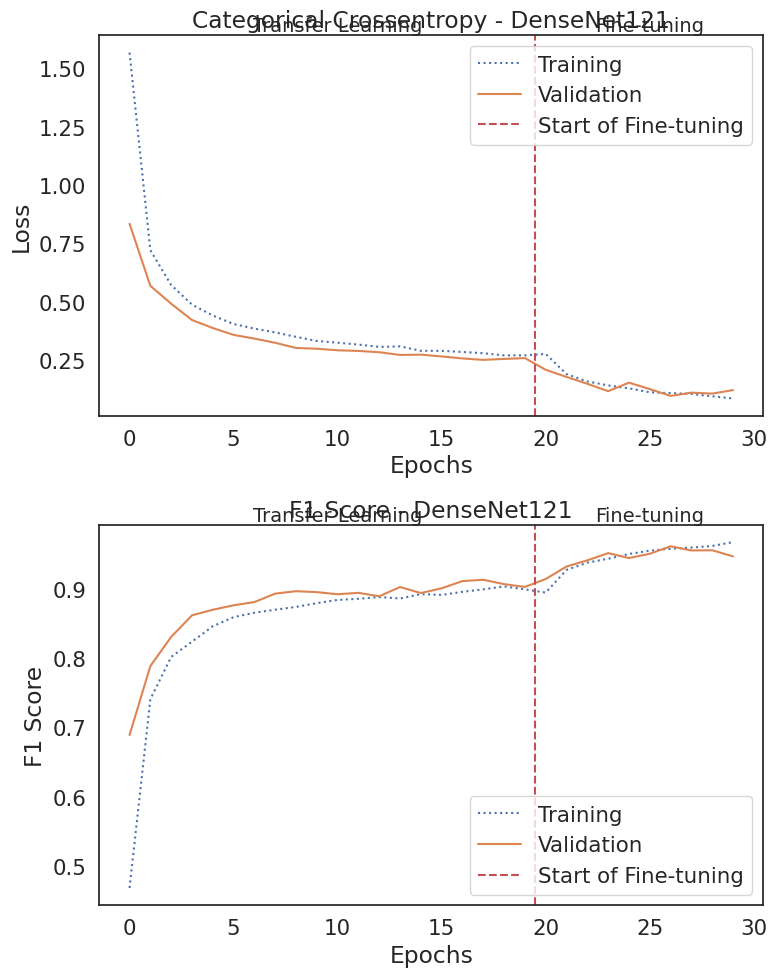

In [ ]:
# Plot loss fucntion and evaluation metric histories
plot_history(history_tl_densenet121, history_ft_densenet121, "DenseNet121")

18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 352ms/step
Accuracy score over the test set: 0.9518
Precision score over the test set: 0.9543
Recall score over the test set: 0.9518
F1 score over the test set: 0.9523


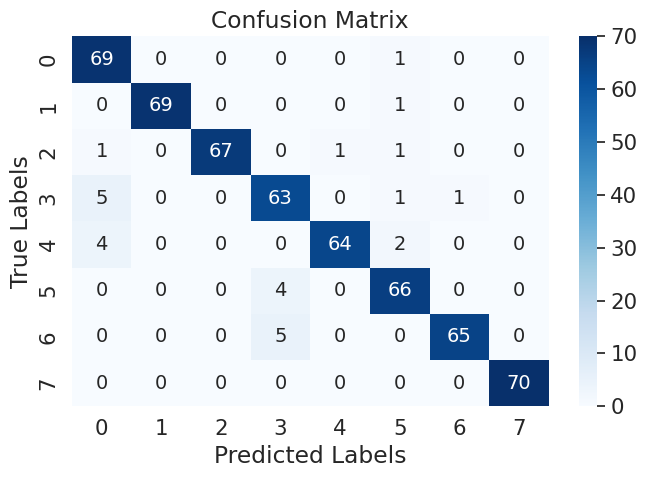

In [ ]:
model = tf.keras.models.load_model(model_filename) # Load model
predict_and_score(model) # Run prediction and evaluation
del model # Delete model

# ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50

tf.keras.backend.clear_session()

# Define base model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)

# Freeze the base model initially
base_model.trainable = False

# Define inputs
inputs = tfkl.Input(shape=INPUT_SHAPE)

# Apply data augmentation
x = data_augmentation(inputs)

# Apply DenseNet-specific preprocessing
x = tfk.applications.resnet.preprocess_input(x)

# Pass through the base model
x = base_model(x)

# Add global average pooling and classifier head
x = tfkl.GlobalAveragePooling2D()(x)
outputs = tfkl.Dense(OUTPUT_SHAPE, activation='softmax')(x)

# Create the complete model
model = tfk.models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=[tfk.metrics.F1Score(average='macro')]
)

# Print the model summary
model.summary(expand_nested=True)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 96, 96, 3)      │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ random_flip          │ (None, 96, 96, 3)      │              0 │ -                      │
│ (RandomFlip)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ random_rotation      │ (None, 96, 96, 3)      │              0 │ -                      │
│ (RandomRotation)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ random_contrast      │ (None, 96, 96, 3)      │              0 │ -                      │
│ (RandomContrast)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ random_brightness    │ (None, 96, 96, 3)      │              0 │ -                      │
│ (RandomBrightness)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ random_zoom          │ (None, 96, 96, 3)      │              0 │ -                      │
│ (RandomZoom)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 96, 96)         │              0 │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 96, 96)         │              0 │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 96, 96)         │              0 │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 96, 96, 3)      │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 96, 96, 3)      │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 3, 3, 2048)     │     23,587,712 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ input_layer          │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ conv1_pad            │ (None, 102, 102, 3)    │              0 │ -                      │
│ (ZeroPadding2D)      

 Total params: 23,604,104 (90.04 MB)

 Trainable params: 16,392 (64.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Transfer learning
history_tl_resnet50 = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights
).history

# Print score
print(f"Transfer learning validation F1Score: {round(max(history_tl_resnet50['val_f1_score'])* 100, 2)}%")

# Unfreeze base model layers for fine-tuning (30% default)
model = unfreeze(model, fine_tuning_lr=FINE_TUNING_LEARNING_RATE)

# Fine-tuning
history_ft_resnet50 = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights
).history

# Print score
print(f"Fine-tuning validation F1Score: {round(max(history_ft_resnet50['val_f1_score'])* 100, 2)}%")

# Save the trained model to a file
model_filename = 'ResNet50.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 24s 175ms/step - f1_score: 0.4450 - loss: 1.5969 - val_f1_score: 0.7502 - val_loss: 0.6936
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - f1_score: 0.7714 - loss: 0.6346 - val_f1_score: 0.7875 - val_loss: 0.5865
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - f1_score: 0.8066 - loss: 0.5414 - val_f1_score: 0.8368 - val_loss: 0.4658
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - f1_score: 0.8290 - loss: 0.4668 - val_f1_score: 0.8196 - val_loss: 0.4838
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - f1_score: 0.8371 - loss: 0.4403 - val_f1_score: 0.8291 - val_loss: 0.4479
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - f1_score: 0.8486 - loss: 0.4055 - val_f1_score: 0.8678 - val_loss: 0.3985
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - f1_score: 0.8532 - loss: 0.3961 - val_f1_score: 0.8641 - val_loss: 0.3877
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - f1_score: 0.8701 - loss: 0.3554 - val_f1_s

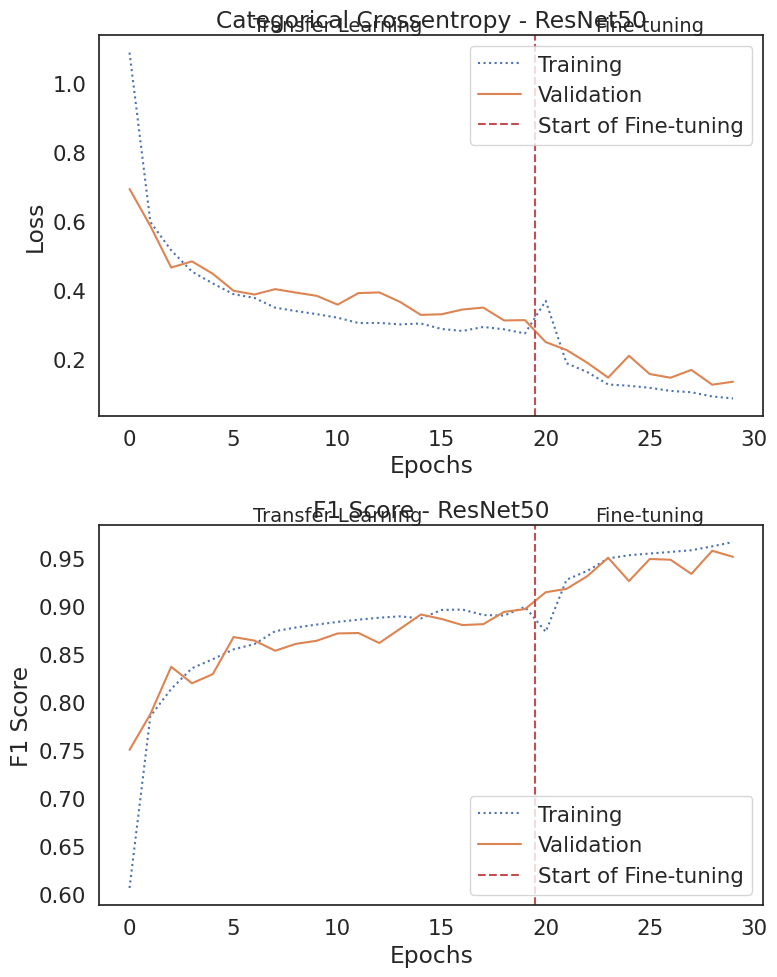

In [ ]:
# Plot loss fucntion and evaluation metric histories
plot_history(history_tl_resnet50, history_ft_resnet50, "ResNet50")

18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step
Accuracy score over the test set: 0.9643
Precision score over the test set: 0.9659
Recall score over the test set: 0.9643
F1 score over the test set: 0.9645


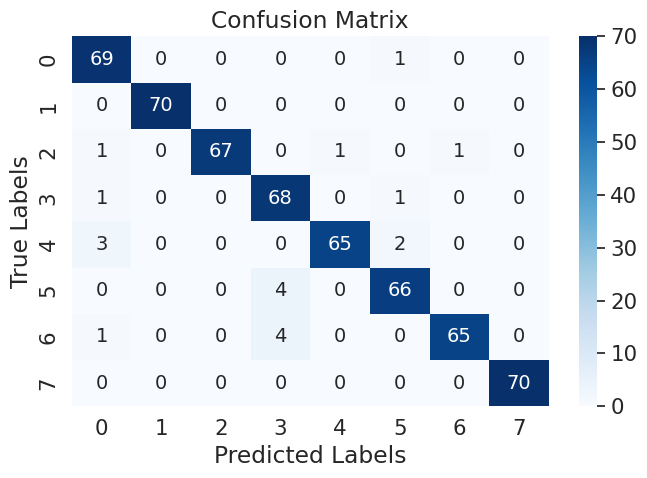

In [ ]:
model = tf.keras.models.load_model(model_filename) # Load model
predict_and_score(model) # Run prediction and evaluation
del model # Delete model

# VGG16

In [ ]:
from tensorflow.keras.applications import VGG16

tf.keras.backend.clear_session()

# Define base model
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)

# Freeze the base model initially
base_model.trainable = False

# Define inputs
inputs = tfkl.Input(shape=INPUT_SHAPE)

# Apply data augmentation
x = data_augmentation(inputs)

# Apply DenseNet-specific preprocessing
x = tfk.applications.vgg16.preprocess_input(x)

# Pass through the base model
x = base_model(x)

# Add global average pooling and classifier head
x = tfkl.GlobalAveragePooling2D()(x)
outputs = tfkl.Dense(OUTPUT_SHAPE, activation='softmax')(x)

# Create the complete model
model = tfk.models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=[tfk.metrics.F1Score(average='macro')]
)

# Print the model summary
model.summary(expand_nested=True)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 96, 96, 3)      │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ random_flip          │ (None, 96, 96, 3)      │              0 │ -                      │
│ (RandomFlip)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ random_rotation      │ (None, 96, 96, 3)      │              0 │ -                      │
│ (RandomRotation)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ random_contrast      │ (None, 96, 96, 3)      │              0 │ -                      │
│ (RandomContrast)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ random_brightness    │ (None, 96, 96, 3)      │              0 │ -                      │
│ (RandomBrightness)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ random_zoom          │ (None, 96, 96, 3)      │              0 │ -                      │
│ (RandomZoom)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 96, 96)         │              0 │ sequential[2][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 96, 96)         │              0 │ sequential[2][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 96, 96)         │              0 │ sequential[2][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 96, 96, 3)      │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 96, 96, 3)      │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 3, 3, 512)      │     14,714,688 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ input_layer          │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ block1_conv1         │ (None, 96, 96, 64)     │          1,792 │ -                      │
│ (Conv2D)             

 Total params: 14,718,792 (56.15 MB)

 Trainable params: 4,104 (16.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Transfer learning
history_tl_vgg16 = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights
).history

# Print score
print(f"Transfer learning validation F1Score: {round(max(history_tl_vgg16['val_f1_score'])* 100, 2)}%")

# Unfreeze base model layers for fine-tuning (30% default)
model = unfreeze(model, fine_tuning_lr=FINE_TUNING_LEARNING_RATE)

# Fine-tuning
history_ft_vgg16 = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights
).history

# Print score
print(f"Fine-tuning validation F1Score: {round(max(history_ft_vgg16['val_f1_score'])* 100, 2)}%")

# Save the trained model to a file
model_filename = 'VGG16.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 199ms/step - f1_score: 0.2566 - loss: 4.7855 - val_f1_score: 0.5124 - val_loss: 1.9484
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - f1_score: 0.5635 - loss: 1.5928 - val_f1_score: 0.6120 - val_loss: 1.3832
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - f1_score: 0.6552 - loss: 1.1227 - val_f1_score: 0.6609 - val_loss: 1.0803
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - f1_score: 0.7030 - loss: 0.9153 - val_f1_score: 0.6763 - val_loss: 1.0260
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - f1_score: 0.7279 - loss: 0.8152 - val_f1_score: 0.7254 - val_loss: 0.8262
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - f1_score: 0.7422 - loss: 0.7361 - val_f1_score: 0.7312 - val_loss: 0.7826
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - f1_score: 0.7672 - loss: 0.6603 - val_f1_score: 0.7421 - val_loss: 0.7383
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - f1_score: 0.7787 - loss: 0.6142 - val_f1_s

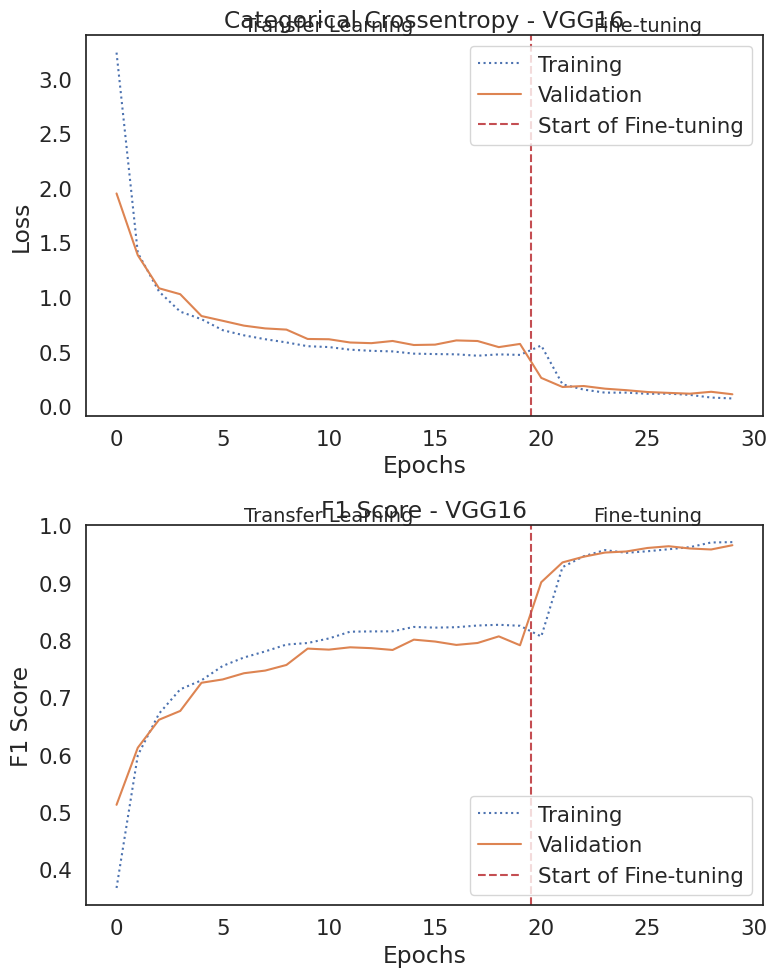

In [ ]:
# Plot loss fucntion and evaluation metric histories
plot_history(history_tl_vgg16, history_ft_vgg16, "VGG16")

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
Accuracy score over the test set: 0.9589
Precision score over the test set: 0.962
Recall score over the test set: 0.9589
F1 score over the test set: 0.9589


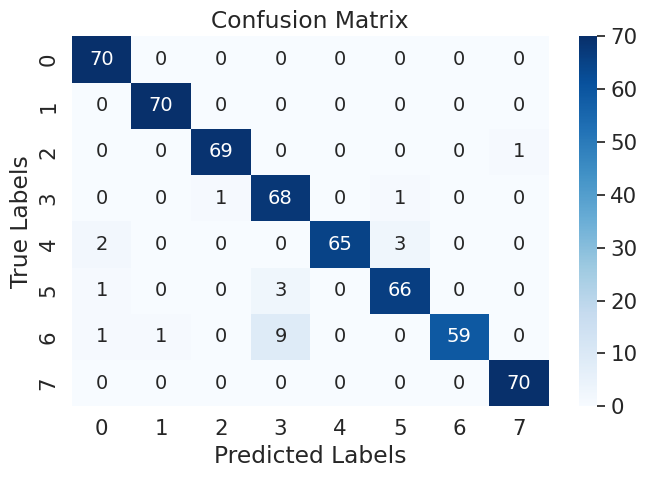

In [ ]:
model = tf.keras.models.load_model(model_filename) # Load model
predict_and_score(model) # Run prediction and evaluation
del model # Delete model

# InceptionV3

In [ ]:
from tensorflow.keras.applications import InceptionV3

tf.keras.backend.clear_session()

# Define base model
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)

# Freeze the base model initially
base_model.trainable = False

# Define inputs
inputs = tfkl.Input(shape=INPUT_SHAPE)

# Apply data augmentation
x = data_augmentation(inputs)

# Apply DenseNet-specific preprocessing
x = tfk.applications.inception_v3.preprocess_input(x)

# Pass through the base model
x = base_model(x)

# Add global average pooling and classifier head
x = tfkl.GlobalAveragePooling2D()(x)
outputs = tfkl.Dense(OUTPUT_SHAPE, activation='softmax')(x)

# Create the complete model
model = tfk.models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=[tfk.metrics.F1Score(average='macro')]
)

# Print the model summary
model.summary(expand_nested=True)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip (RandomFlip)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation                 │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_contrast                 │ (None, 96, 96, 3)           │               0 │
│ (RandomContrast)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_brightness               │ (None, 96, 96, 3)           │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom (RandomZoom)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 1, 1, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2d (Conv2D)                 │ (None, 47, 47, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ batch_normalization             │ (None, 47, 47, 32)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ activation (Activation)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2d_1 (Conv2D)               │ (None, 45, 45, 32)          │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ batch_normalization_1           │ (None, 45, 45, 32)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ activation_1 (Activation)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)          │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ batch_normalization_2           │ (None, 45, 45, 64)          │             1

 Total params: 21,819,176 (83.23 MB)

 Trainable params: 16,392 (64.03 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
# Transfer learning
history_tl_inceptionv3 = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights
).history

# Print score
print(f"Transfer learning validation F1Score: {round(max(history_tl_inceptionv3['val_f1_score'])* 100, 2)}%")

# Unfreeze base model layers for fine-tuning (30% default)
model = unfreeze(model, fine_tuning_lr=FINE_TUNING_LEARNING_RATE)

# Fine-tuning
history_ft_inceptionv3 = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights
).history

# Print score
print(f"Fine-tuning validation F1Score: {round(max(history_ft_inceptionv3['val_f1_score'])* 100, 2)}%")

# Save the trained model to a file
model_filename = 'InceptionV3.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - f1_score: 0.4752 - loss: 1.4623 - val_f1_score: 0.7365 - val_loss: 0.7199
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - f1_score: 0.7254 - loss: 0.7470 - val_f1_score: 0.7776 - val_loss: 0.6007
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - f1_score: 0.7593 - loss: 0.6679 - val_f1_score: 0.7948 - val_loss: 0.5608
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - f1_score: 0.7605 - loss: 0.6441 - val_f1_score: 0.7958 - val_loss: 0.5369
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - f1_score: 0.7829 - loss: 0.5880 - val_f1_score: 0.7965 - val_loss: 0.5413
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - f1_score: 0.7920 - loss: 0.5561 - val_f1_score: 0.7968 - val_loss: 0.5415
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - f1_score: 0.7894 - loss: 0.5559 - val_f1_score: 0.7949 - val_loss: 0.5049
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - f1_score: 0.7860 - loss: 0.5699 - val_f1_score: 0.7907

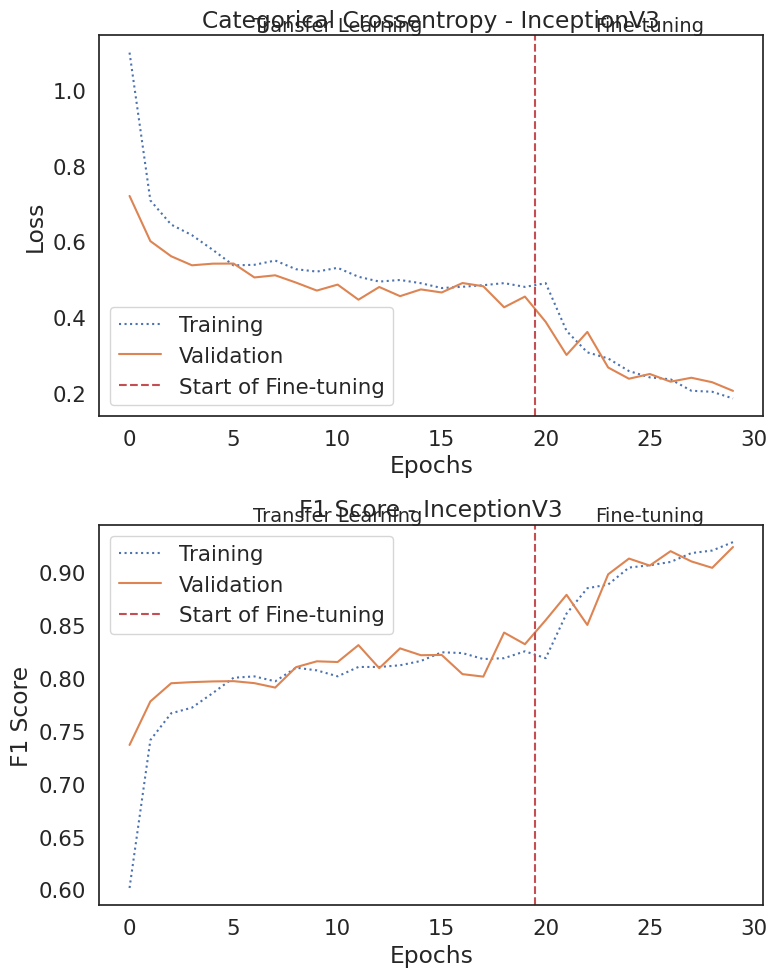

In [ ]:
# Plot loss fucntion and evaluation metric histories
plot_history(history_tl_inceptionv3, history_ft_inceptionv3, "InceptionV3")

18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 296ms/step
Accuracy score over the test set: 0.9268
Precision score over the test set: 0.9329
Recall score over the test set: 0.9268
F1 score over the test set: 0.9285


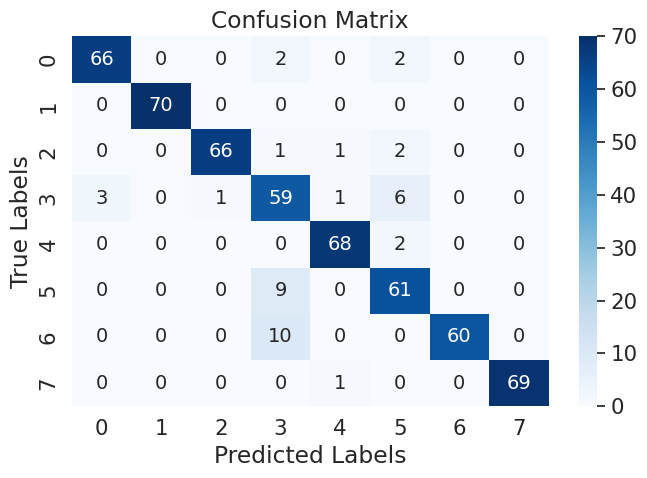

In [ ]:
model = tf.keras.models.load_model(model_filename) # Load model
predict_and_score(model) # Run prediction and evaluation
del model # Delete model

# MobileNetV3Large

In [ ]:
from tensorflow.keras.applications import MobileNetV3Large

tf.keras.backend.clear_session()

# Define base model
base_model = MobileNetV3Large(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE,
    pooling='avg',
    include_preprocessing=True
)

# Freeze the base model initially
base_model.trainable = False

# Define inputs
inputs = tfkl.Input(shape=INPUT_SHAPE)

# Apply data augmentation
x = data_augmentation(inputs)

# Pass through the base model
x = base_model(x)

# Add classifier head
outputs = tfkl.Dense(OUTPUT_SHAPE, activation='softmax')(x)

# Create the complete model
model = tfk.models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=[tfk.metrics.F1Score(average='macro')]
)

# Print the model summary
model.summary(expand_nested=True)

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip (RandomFlip)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation                 │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_contrast                 │ (None, 96, 96, 3)           │               0 │
│ (RandomContrast)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_brightness               │ (None, 96, 96, 3)           │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom (RandomZoom)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 960)                 │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv (Conv2D)                   │ (None, 48, 48, 16)          │             432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv_bn (BatchNormalization)    │ (None, 48, 48, 16)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ activation (Activation)         │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise         │ (None, 48, 48, 16)          │             144 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise_bn      │ (None, 48, 48, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ re_lu (ReLU)                    │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_project (Conv2D)  │ (None, 48, 48, 16)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_project_bn        │ (None, 48, 48, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,004,040 (11.46 MB)

 Trainable params: 7,688 (30.03 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [ ]:
# Transfer learning
history_tl_mobilenetv3 = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights
).history

# Print score
print(f"Transfer learning validation F1Score: {round(max(history_tl_densenet121['val_f1_score'])* 100, 2)}%")

# Unfreeze base model layers for fine-tuning (30% default)
model = unfreeze(model, fine_tuning_lr=FINE_TUNING_LEARNING_RATE)

# Fine-tuning
history_ft_mobilenetv3 = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights
).history

# Print score
print(f"Fine-tuning validation F1Score: {round(max(history_ft_densenet121['val_f1_score'])* 100, 2)}%")

# Save the trained model to a file
model_filename = 'MobileNetV3Large.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - f1_score: 0.3034 - loss: 2.1171 - val_f1_score: 0.7180 - val_loss: 0.7695
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - f1_score: 0.7582 - loss: 0.7141 - val_f1_score: 0.7825 - val_loss: 0.5405
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - f1_score: 0.8156 - loss: 0.5406 - val_f1_score: 0.8260 - val_loss: 0.4448
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - f1_score: 0.8391 - loss: 0.4722 - val_f1_score: 0.8309 - val_loss: 0.4248
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - f1_score: 0.8537 - loss: 0.4223 - val_f1_score: 0.8547 - val_loss: 0.3740
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - f1_score: 0.8633 - loss: 0.3878 - val_f1_score: 0.8639 - val_loss: 0.3435
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - f1_score: 0.8757 - loss: 0.3629 - val_f1_score: 0.8645 - val_loss: 0.3363
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - f1_score: 0.8806 - loss: 0.3398 - val_f1_score: 0.8630 - 

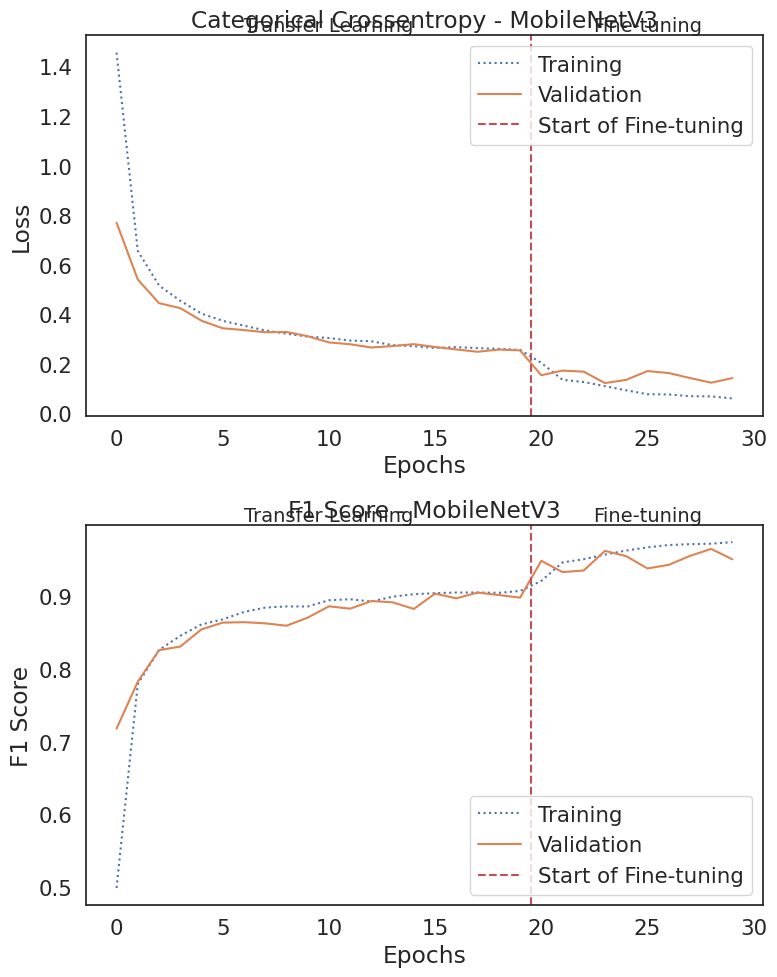

In [ ]:
# Plot loss fucntion and evaluation metric histories
plot_history(history_tl_mobilenetv3, history_ft_mobilenetv3, "MobileNetV3")

18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step
Accuracy score over the test set: 0.9625
Precision score over the test set: 0.964
Recall score over the test set: 0.9625
F1 score over the test set: 0.9626


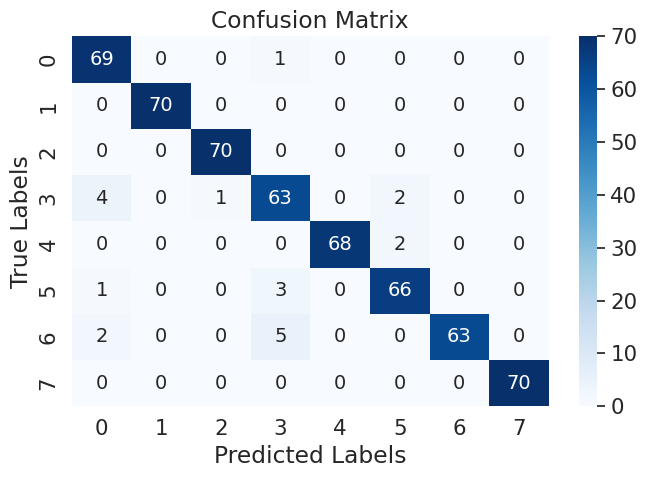

In [ ]:
model = tf.keras.models.load_model(model_filename) # Load model
predict_and_score(model) # Run prediction and evaluation
del model # Delete model

# EfficientNetB0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

tf.keras.backend.clear_session()

# Define base model
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)

# Freeze the base model initially
base_model.trainable = False

# Define inputs
inputs = tfkl.Input(shape=INPUT_SHAPE)

# Apply data augmentation
x = data_augmentation(inputs)

# Apply DenseNet-specific preprocessing
x = tfk.applications.efficientnet.preprocess_input(x)

# Pass through the base model
x = base_model(x)

# Add global average pooling and classifier head
x = tfkl.GlobalAveragePooling2D()(x)
outputs = tfkl.Dense(OUTPUT_SHAPE, activation='softmax')(x)

# Create the complete model
model = tfk.models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=[tfk.metrics.F1Score(average='macro')]
)

# Print the model summary
model.summary(expand_nested=True)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip (RandomFlip)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation                 │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_contrast                 │ (None, 96, 96, 3)           │               0 │
│ (RandomContrast)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_brightness               │ (None, 96, 96, 3)           │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom (RandomZoom)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 3, 3, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ normalization (Normalization)   │ (None, 96, 96, 3)           │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling_1 (Rescaling)         │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv_pad (ZeroPadding2D)   │ (None, 97, 97, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, 48, 48, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, 48, 48, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_dwconv                  │ (None, 48, 48, 32)          │             288 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_bn (BatchNormalization) │ (None, 48, 48, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_activation (Activation) │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,059,819 (15.49 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Transfer learning
history_tl_efficientnetb0 = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights
).history

# Print score
print(f"Transfer learning validation F1Score: {round(max(history_tl_efficientnetb0['val_f1_score'])* 100, 2)}%")

# Unfreeze base model layers for fine-tuning (30% default)
model = unfreeze(model, fine_tuning_lr=FINE_TUNING_LEARNING_RATE)

# Fine-tuning
history_ft_efficientnetb0 = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights
).history

# Print score
print(f"Fine-tuning validation F1Score: {round(max(history_ft_efficientnetb0['val_f1_score'])* 100, 2)}%")

# Save the trained model to a file
model_filename = 'EfficientNetB0.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - f1_score: 0.4221 - loss: 1.5575 - val_f1_score: 0.7257 - val_loss: 0.8435
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - f1_score: 0.7201 - loss: 0.8224 - val_f1_score: 0.7663 - val_loss: 0.7009
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - f1_score: 0.7690 - loss: 0.6712 - val_f1_score: 0.7939 - val_loss: 0.6272
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - f1_score: 0.7934 - loss: 0.5904 - val_f1_score: 0.7991 - val_loss: 0.5824
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - f1_score: 0.8075 - loss: 0.5567 - val_f1_score: 0.8115 - val_loss: 0.5597
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - f1_score: 0.8121 - loss: 0.5352 - val_f1_score: 0.8113 - val_loss: 0.5271
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - f1_score: 0.8255 - loss: 0.4908 - val_f1_score: 0.8228 - val_loss: 0.5049
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - f1_score: 0.8323 - loss: 0.4718 - val_f1_score: 0.827

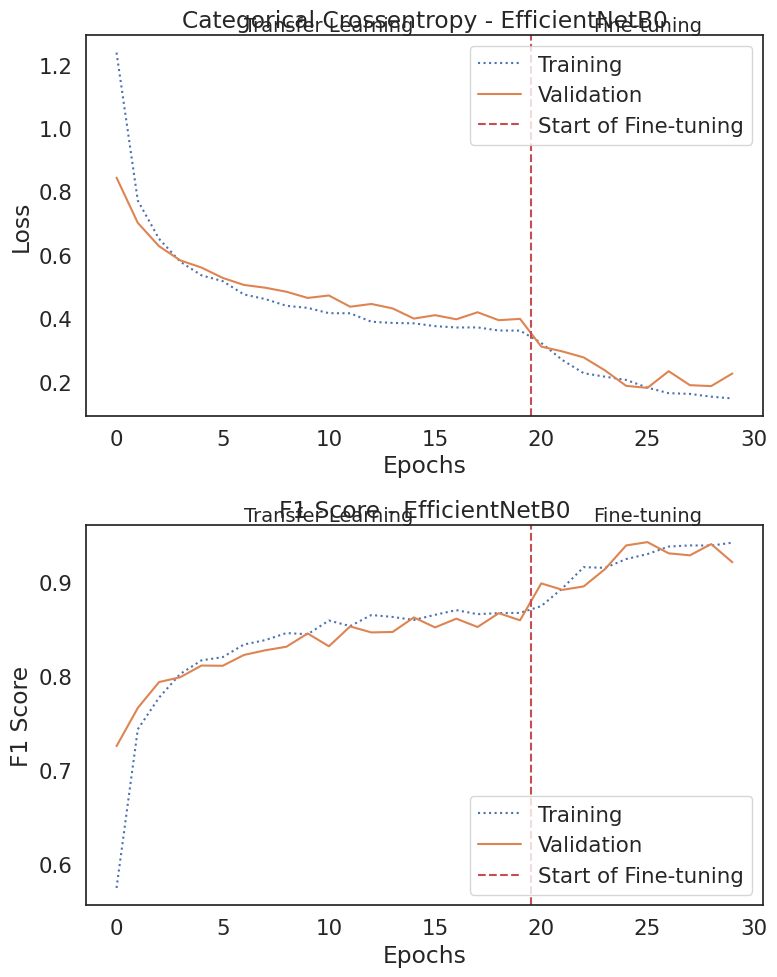

In [ ]:
# Plot loss fucntion and evaluation metric histories
plot_history(history_tl_efficientnetb0, history_ft_efficientnetb0, "EfficientNetB0")

18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 281ms/step
Accuracy score over the test set: 0.7929
Precision score over the test set: 0.8612
Recall score over the test set: 0.7929
F1 score over the test set: 0.7933


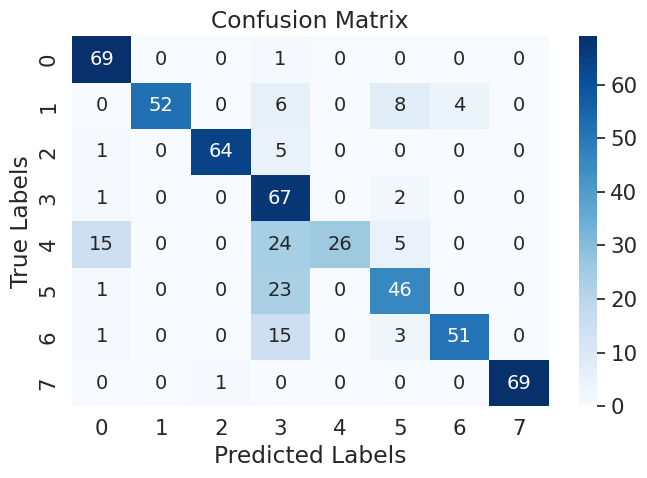

In [ ]:
model = tf.keras.models.load_model(model_filename) # Load model
predict_and_score(model) # Run prediction and evaluation
del model # Delete model

# EfficientNetV2S

In [ ]:
from tensorflow.keras.applications import EfficientNetV2S

tf.keras.backend.clear_session()

# Define base model
base_model = EfficientNetV2S(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE,
    pooling="avg",
    include_preprocessing=True
)

# Freeze the base model initially
base_model.trainable = False

# Define inputs
inputs = tfkl.Input(shape=INPUT_SHAPE)

# Apply data augmentation
x = data_augmentation(inputs)

# Pass through the base model
x = base_model(x)

# Add classifier head
outputs = tfkl.Dense(OUTPUT_SHAPE, activation='softmax')(x)

# Create the complete model
model = tfk.models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=[tfk.metrics.F1Score(average='macro')]
)

# Print the model summary
model.summary(expand_nested=True)

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip (RandomFlip)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation                 │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_contrast                 │ (None, 96, 96, 3)           │               0 │
│ (RandomContrast)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_brightness               │ (None, 96, 96, 3)           │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom (RandomZoom)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-s (Functional)        │ (None, 1280)                │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, 48, 48, 24)          │             648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, 48, 48, 24)          │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_conv (Conv2D)   │ (None, 48, 48, 24)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_bn              │ (None, 48, 48, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_activation      │ (None, 48, 48, 24)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_add (Add)               │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_conv (Conv2D)   │ (None, 48, 48, 24)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_bn              │ (None, 48, 48, 24)          │              

 Total params: 20,341,608 (77.60 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [ ]:
# Transfer learning
history_tl_efficientnetv2s = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights
).history

# Printscore
print(f"Transfer learning validation F1Score: {round(max(history_tl_efficientnetv2s['val_f1_score'])* 100, 2)}%")

# Unfreeze base model layers for fine-tuning (30% default)
model = unfreeze(model, fine_tuning_lr=FINE_TUNING_LEARNING_RATE)

# Fine-tuning
history_ft_efficientnetv2s = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights
).history

# Print score
print(f"Fine-tuning validation F1Score: {round(max(history_ft_efficientnetv2s['val_f1_score'])* 100, 2)}%")

# Save the trained model to a file
model_filename = 'EfficientNetV2S.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 44s 250ms/step - f1_score: 0.4122 - loss: 1.6504 - val_f1_score: 0.7089 - val_loss: 0.9413
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - f1_score: 0.7090 - loss: 0.9170 - val_f1_score: 0.7895 - val_loss: 0.7214
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - f1_score: 0.7594 - loss: 0.7499 - val_f1_score: 0.8165 - val_loss: 0.6244
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - f1_score: 0.7854 - loss: 0.6646 - val_f1_score: 0.8300 - val_loss: 0.5627
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - f1_score: 0.7968 - loss: 0.6096 - val_f1_score: 0.8413 - val_loss: 0.5213
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - f1_score: 0.8241 - loss: 0.5503 - val_f1_score: 0.8392 - val_loss: 0.5004
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - f1_score: 0.8077 - loss: 0.5511 - val_f1_score: 0.8530 - val_loss: 0.4720
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - f1_score: 0.8312 - loss: 0.5098 - val_f1_s

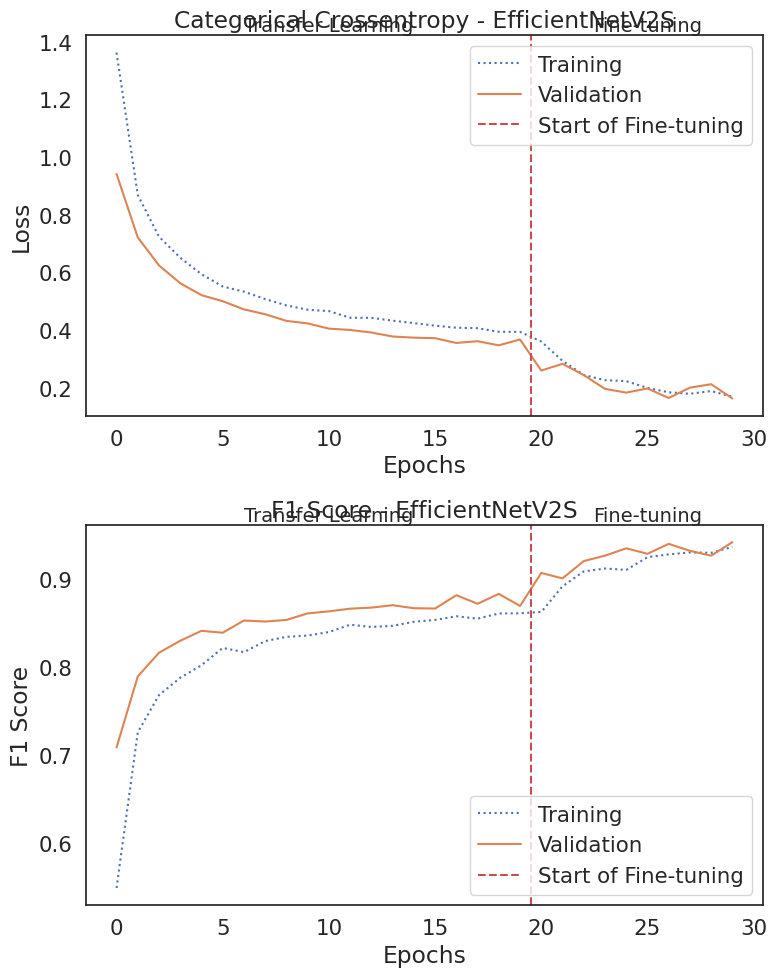

In [ ]:
# Plot loss fucntion and evaluation metric histories
plot_history(history_tl_efficientnetv2s, history_ft_efficientnetv2s, "EfficientNetV2S")

18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 358ms/step
Accuracy score over the test set: 0.9661
Precision score over the test set: 0.9688
Recall score over the test set: 0.9661
F1 score over the test set: 0.9664


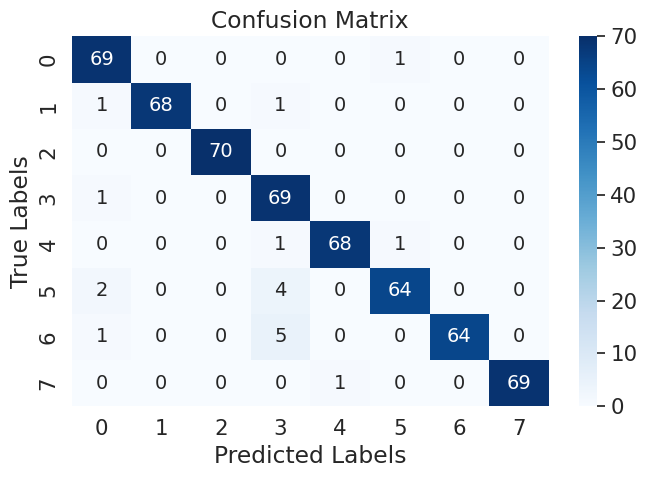

In [ ]:
model = tf.keras.models.load_model(model_filename) # Load model
predict_and_score(model) # Run prediction and evaluation
del model # Delete model

# EfficientNetV2M

In [ ]:
from tensorflow.keras.applications import EfficientNetV2M

tf.keras.backend.clear_session()

# Define base model
base_model = EfficientNetV2M(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE,
    pooling="avg",
    include_preprocessing=True
)

# Freeze the base model initially
base_model.trainable = False

# Define inputs
inputs = tfkl.Input(shape=INPUT_SHAPE)

# Apply data augmentation
x = data_augmentation(inputs)

# Pass through the base model
x = base_model(x)

# Add classifier head
outputs = tfkl.Dense(OUTPUT_SHAPE, activation='softmax')(x)

# Create the complete model
model = tfk.models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=[tfk.metrics.F1Score(average='macro')]
)

# Print the model summary
model.summary(expand_nested=True)

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip (RandomFlip)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation                 │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_contrast                 │ (None, 96, 96, 3)           │               0 │
│ (RandomContrast)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_brightness               │ (None, 96, 96, 3)           │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom (RandomZoom)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-m (Functional)        │ (None, 1280)                │      53,150,388 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, 48, 48, 24)          │             648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, 48, 48, 24)          │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_conv (Conv2D)   │ (None, 48, 48, 24)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_bn              │ (None, 48, 48, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_activation      │ (None, 48, 48, 24)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_add (Add)               │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_conv (Conv2D)   │ (None, 48, 48, 24)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_bn              │ (None, 48, 48, 24)          │              

 Total params: 53,160,636 (202.79 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 53,150,388 (202.75 MB)

In [ ]:
# Transfer learning
history_tl_efficientnetv2m = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights
).history

# Print score
print(f"Transfer learning validation F1Score: {round(max(history_tl_efficientnetv2m['val_f1_score'])* 100, 2)}%")

# Unfreeze base model layers for fine-tuning (30% default)
model = unfreeze(model, fine_tuning_lr=FINE_TUNING_LEARNING_RATE)

# Fine-tuning
history_ft_efficientnetv2m = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights
).history

# Print score
print(f"Fine-tuning validation F1Score: {round(max(history_ft_efficientnetv2m['val_f1_score'])* 100, 2)}%")

# Save the trained model to a file
model_filename = 'EfficientNetV2M.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 353ms/step - f1_score: 0.3885 - loss: 1.7730 - val_f1_score: 0.7548 - val_loss: 0.9962
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 30s 224ms/step - f1_score: 0.6600 - loss: 1.1661 - val_f1_score: 0.7967 - val_loss: 0.7445
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 225ms/step - f1_score: 0.7046 - loss: 0.9847 - val_f1_score: 0.8175 - val_loss: 0.6280
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - f1_score: 0.7197 - loss: 0.8794 - val_f1_score: 0.8302 - val_loss: 0.5583
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 225ms/step - f1_score: 0.7515 - loss: 0.7849 - val_f1_score: 0.8257 - val_loss: 0.5218
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - f1_score: 0.7537 - loss: 0.7723 - val_f1_score: 0.8358 - val_loss: 0.4826
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 217ms/step - f1_score: 0.7749 - loss: 0.7025 - val_f1_score: 0.8478 - val_loss: 0.4607
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 213ms/step - f1_score: 0.7777 - loss: 0.6847 - val_f1_s

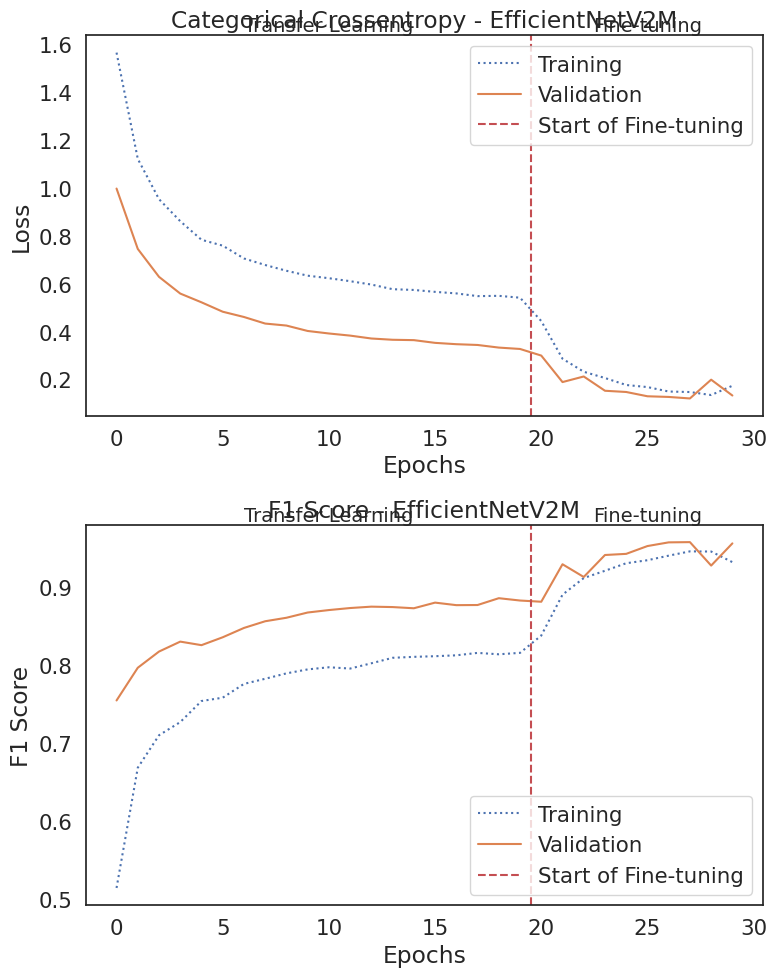

In [ ]:
# Plot loss fucntion and evaluation metric histories
plot_history(history_tl_efficientnetv2m, history_ft_efficientnetv2m, "EfficientNetV2M")

18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 632ms/step
Accuracy score over the test set: 0.9679
Precision score over the test set: 0.9694
Recall score over the test set: 0.9679
F1 score over the test set: 0.968


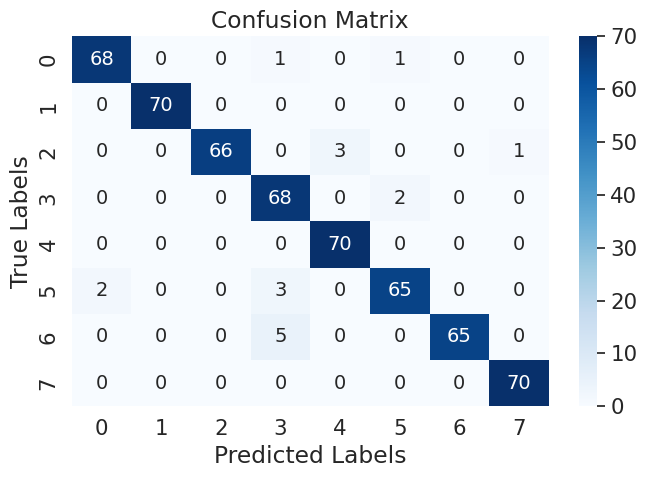

In [ ]:
model = tf.keras.models.load_model(model_filename) # Load model
predict_and_score(model) # Run prediction and evaluation
del model # Delete model

# EfficientNetV2L

In [ ]:
from tensorflow.keras.applications import EfficientNetV2L

tf.keras.backend.clear_session()

# Define base model
base_model = EfficientNetV2L(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)

# Freeze the base model initially
base_model.trainable = False

# Define inputs
inputs = tfkl.Input(shape=INPUT_SHAPE)

# Apply data augmentation
x = data_augmentation(inputs)

# Apply DenseNet-specific preprocessing
x = tfk.applications.densenet.preprocess_input(x)

# Pass through the base model
x = base_model(x)

# Add global average pooling and classifier head
x = tfkl.GlobalAveragePooling2D()(x)
outputs = tfkl.Dense(OUTPUT_SHAPE, activation='softmax')(x)

# Create the complete model
model = tfk.models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=[tfk.metrics.F1Score(average='macro')]
)

# Print the model summary
model.summary(expand_nested=True)

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip (RandomFlip)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation                 │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_contrast                 │ (None, 96, 96, 3)           │               0 │
│ (RandomContrast)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_brightness               │ (None, 96, 96, 3)           │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom (RandomZoom)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ add (Add)                            │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_1 (TrueDivide)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-l (Functional)        │ (None, 3, 3, 1280)          │     117,746,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, 48, 48, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, 48, 48, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_conv (Conv2D)   │ (None, 48, 48, 32)          │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_bn              │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_activation      │ (None, 48, 48, 32)          │               0 │
│ (Activation)                         │                             │              

 Total params: 117,757,096 (449.21 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 117,746,848 (449.17 MB)

In [ ]:
# Transfer learning
history_tl_efficientnetv2l = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights
).history

# Print score
print(f"Transfer learning validation F1Score: {round(max(history_tl_efficientnetv2l['val_f1_score'])* 100, 2)}%")

# Unfreeze base model layers for fine-tuning (30% default)
model = unfreeze(model, fine_tuning_lr=FINE_TUNING_LEARNING_RATE)

# Fine-tuning
history_ft_efficientnetv2l = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights
).history

# Print score
print(f"Fine-tuning validation F1Score: {round(max(history_ft_efficientnetv2l['val_f1_score'])* 100, 2)}%")

# Save the trained model to a file
model_filename = 'EfficientNetV2L.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 94s 581ms/step - f1_score: 0.1286 - loss: 2.0801 - val_f1_score: 0.1495 - val_loss: 2.0352
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 66s 385ms/step - f1_score: 0.1768 - loss: 2.0268 - val_f1_score: 0.2097 - val_loss: 1.9943
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 361ms/step - f1_score: 0.2042 - loss: 1.9958 - val_f1_score: 0.2304 - val_loss: 1.9550
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 364ms/step - f1_score: 0.2355 - loss: 1.9668 - val_f1_score: 0.2772 - val_loss: 1.9035
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 30s 374ms/step - f1_score: 0.2501 - loss: 1.9410 - val_f1_score: 0.3861 - val_loss: 1.8642
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 381ms/step - f1_score: 0.2684 - loss: 1.9226 - val_f1_score: 0.3803 - val_loss: 1.8414
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 43s 401ms/step - f1_score: 0.2864 - loss: 1.8959 - val_f1_score: 0.4319 - val_loss: 1.8020
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 380ms/step - f1_score: 0.2903 - loss: 1.8751 - val_f1_s

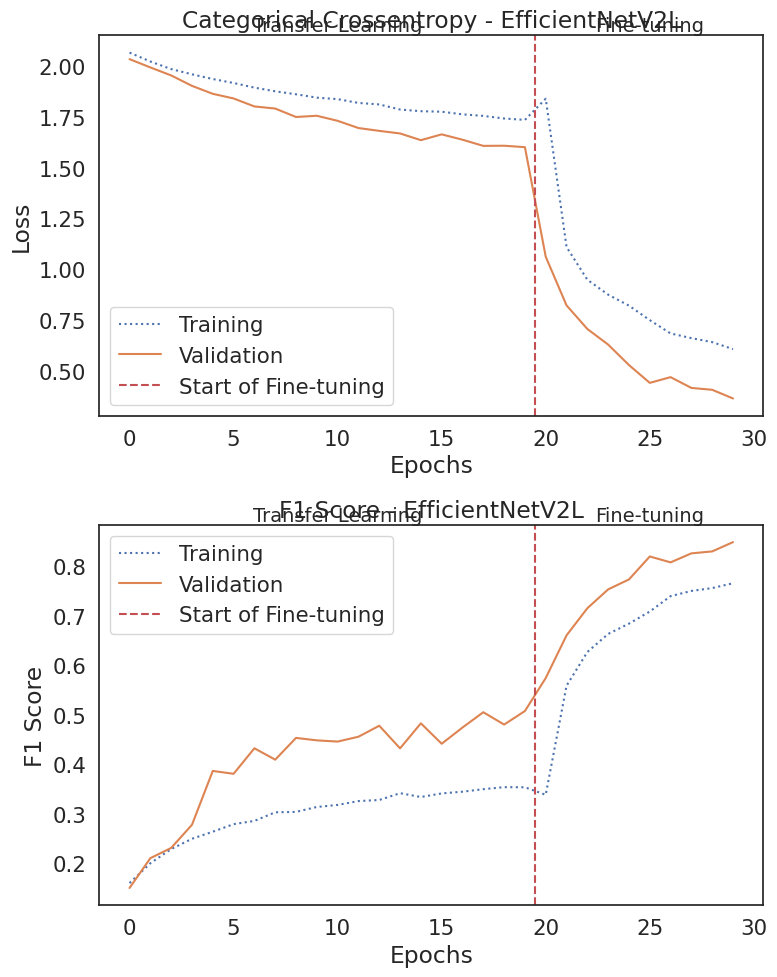

In [ ]:
# Plot loss fucntion and evaluation metric histories
plot_history(history_tl_efficientnetv2l, history_ft_efficientnetv2l, "EfficientNetV2L")

18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 806ms/step
Accuracy score over the test set: 0.8357
Precision score over the test set: 0.8656
Recall score over the test set: 0.8357
F1 score over the test set: 0.8354


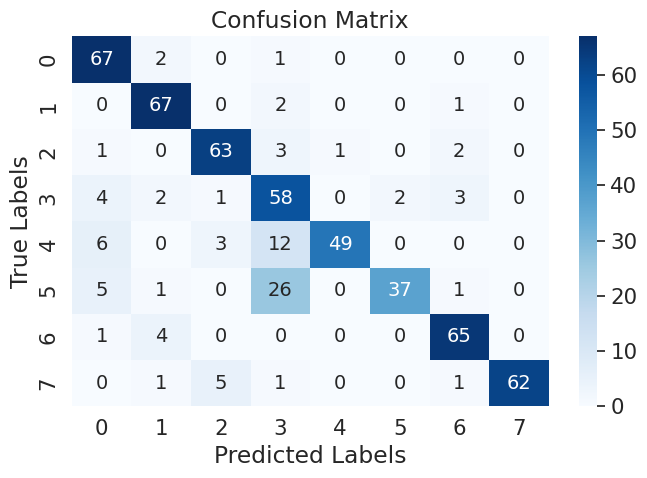

In [ ]:
model = tf.keras.models.load_model(model_filename) # Load model
predict_and_score(model) # Run prediction and evaluation
del model # Delete model

# Model Comparison

In [ ]:
import json

model_histories = {
    "DenseNet121": (history_tl_densenet121, history_ft_densenet121),
    "ResNet50": (history_tl_resnet50, history_ft_resnet50),
    "VGG16": (history_tl_vgg16, history_ft_vgg16),
    "InceptionV3": (history_tl_inceptionv3, history_ft_inceptionv3),
    "MobileNetV3": (history_tl_mobilenetv3, history_ft_mobilenetv3),
    "EfficientNetB0": (history_tl_efficientnetb0, history_ft_efficientnetb0),
    "EfficientNetV2S": (history_tl_efficientnetv2s, history_ft_efficientnetv2s),
    "EfficientNetV2M": (history_tl_efficientnetv2m, history_ft_efficientnetv2m),
    "EfficientNetV2L": (history_tl_efficientnetv2l, history_ft_efficientnetv2l)
}

# Create a dictionary to hold the histories in a serializable format
history_dict = {model_name: (history[0], history[1]) for model_name, history in model_histories.items()}

# Save to JSON
with open('model_histories.json', 'w') as json_file:
    json.dump(history_dict, json_file, indent=4)

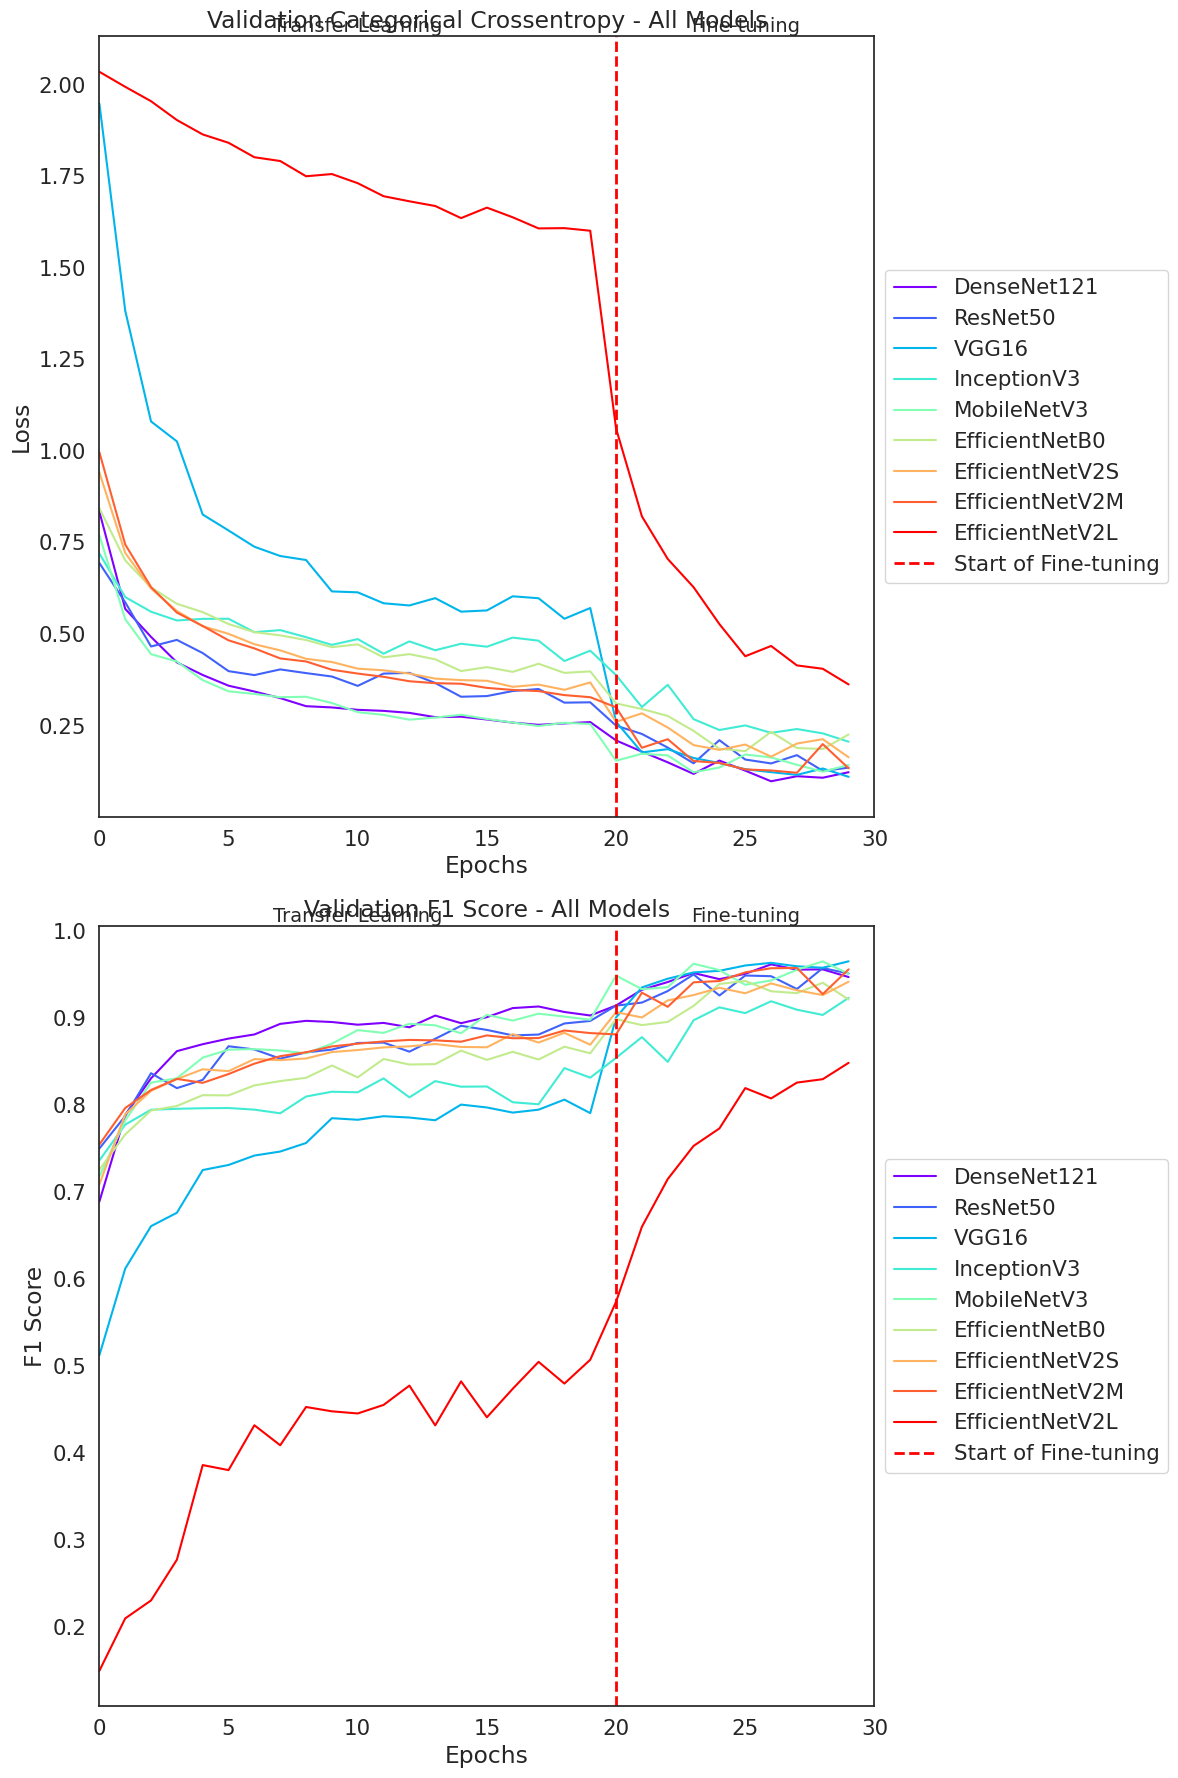

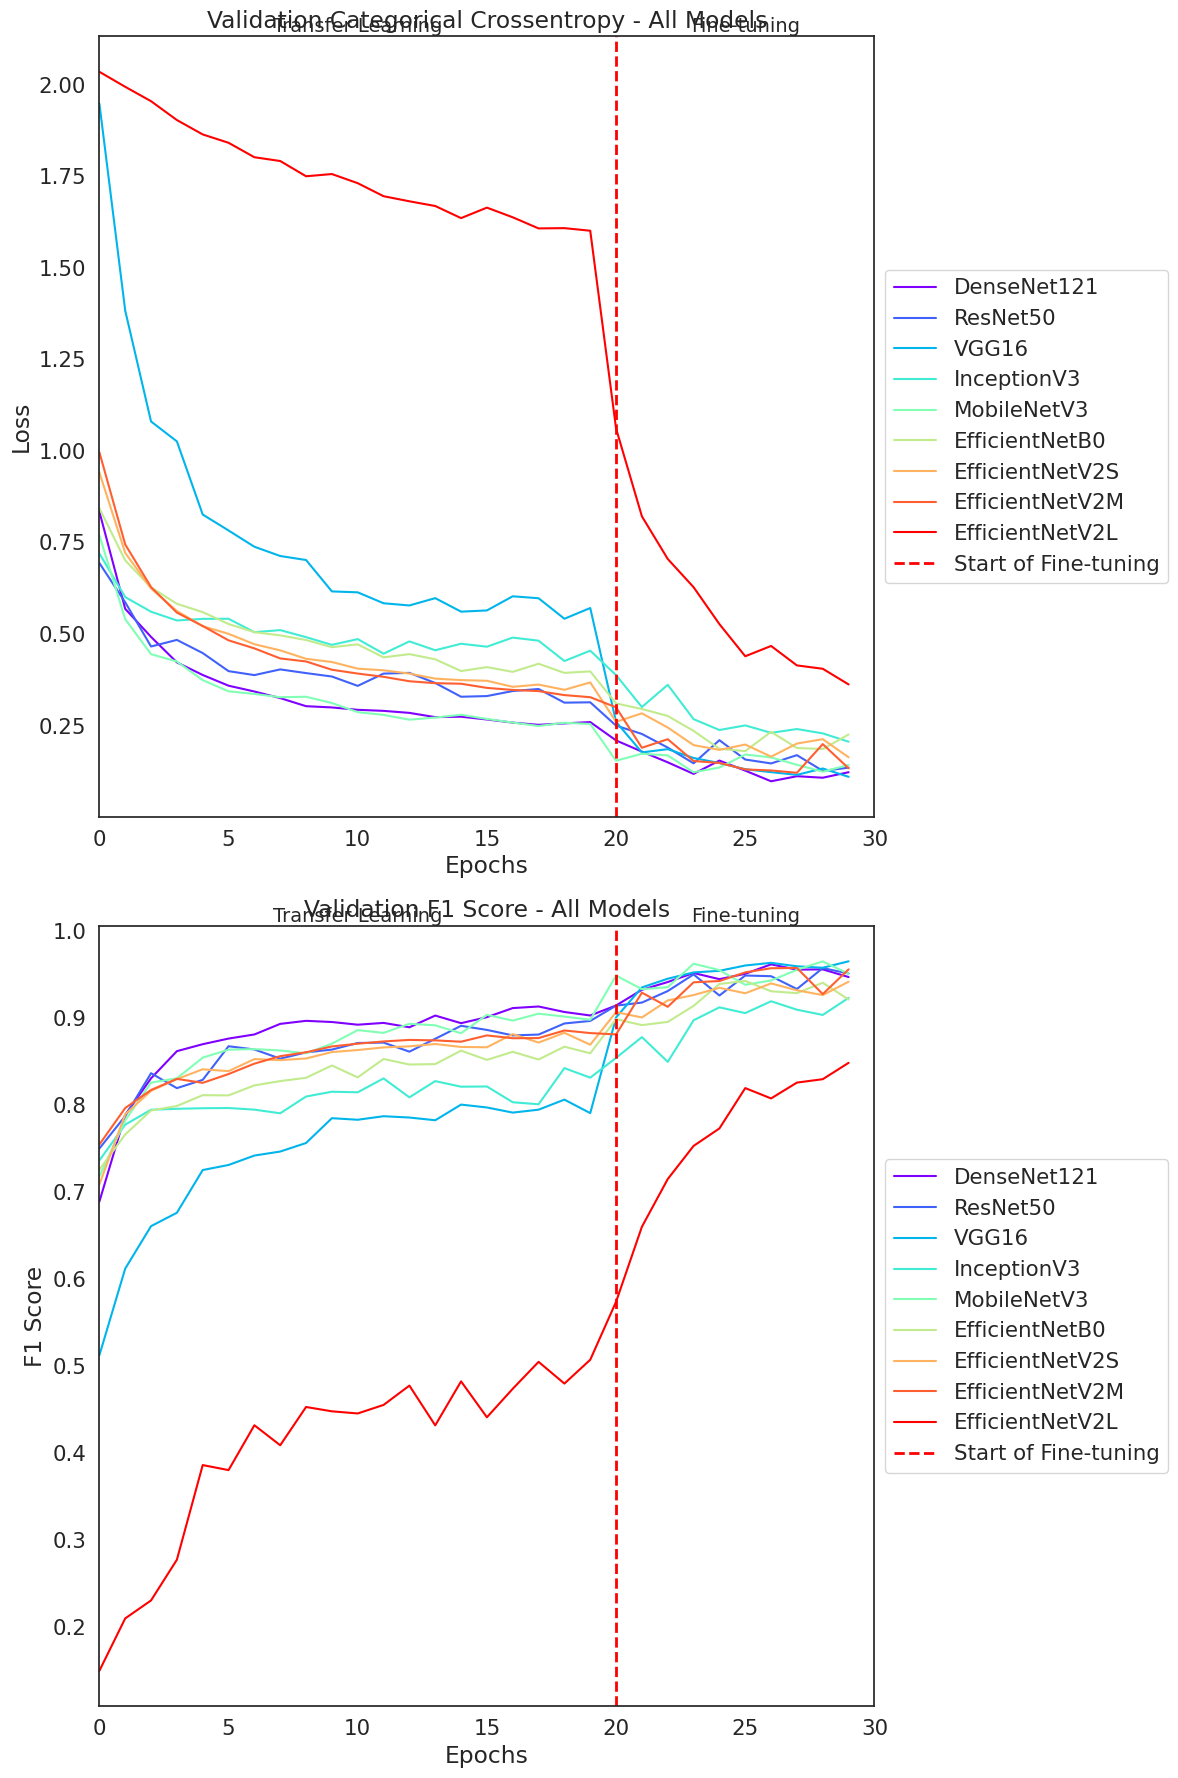

In [ ]:
def compare_histories(model_histories):
    # Create figures and axes
    fig, axs = plt.subplots(2, figsize=(12, 18))

    # Define a color cycle
    colors = plt.cm.rainbow(np.linspace(0, 1, len(model_histories)))

    # Get the number of epochs for transfer learning and fine-tuning
    first_model = next(iter(model_histories.values()))
    tl_epochs = len(first_model[0]['val_loss'])
    ft_epochs = len(first_model[1]['val_loss'])
    total_epochs = tl_epochs + ft_epochs

    # Plot each model's history
    for (model_name, (history_tl, history_ft)), color in zip(model_histories.items(), colors):
        # Extract relevant metrics
        tl_loss = history_tl['val_loss']
        tl_f1 = history_tl['val_f1_score']
        ft_loss = history_ft['val_loss']
        ft_f1 = history_ft['val_f1_score']

        # Concatenate transfer learning and fine-tuning histories
        loss = tl_loss + ft_loss
        f1 = tl_f1 + ft_f1

        # Plot Categorical Crossentropy
        axs[0].plot(loss, color=color, label=model_name)

        # Plot F1 Score
        axs[1].plot(f1, color=color, label=model_name)

    # Add a single vertical line to separate transfer learning and fine-tuning
    for ax in axs:
        ax.axvline(x=tl_epochs, color='red', linestyle='--', linewidth=2, label='Start of Fine-tuning')

    # Set titles and labels
    axs[0].set_title('Validation Categorical Crossentropy - All Models')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    axs[1].set_title('Validation F1 Score - All Models')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('F1 Score')
    axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Add text annotations
    for ax in axs:
        ax.text(tl_epochs/2, ax.get_ylim()[1], 'Transfer Learning',
                horizontalalignment='center', verticalalignment='bottom')
        ax.text(tl_epochs + ft_epochs/2, ax.get_ylim()[1], 'Fine-tuning',
                horizontalalignment='center', verticalalignment='bottom')

    # Set x-axis limits
    for ax in axs:
        ax.set_xlim(0, total_epochs)

    # Layout so plots do not overlap
    fig.tight_layout()

    # Save the plot to a file
    plt.savefig('comparison_plot.png', bbox_inches='tight')

    # Show plot
    plt.show()

compare_histories(model_histories)

Keys in the JSON file: dict_keys(['DenseNet121', 'ResNet50', 'VGG16', 'InceptionV3', 'MobileNetV3', 'EfficientNetB0', 'EfficientNetV2S', 'EfficientNetV2M', 'EfficientNetV2L'])
Example model data structure: [{'f1_score': [0.46798136830329895, 0.7407864928245544, 0.8020464181900024, 0.824006974697113, 0.8463844060897827, 0.8595035076141357, 0.8658778071403503, 0.8702831268310547, 0.8743133544921875, 0.8797205686569214, 0.8844000101089478, 0.8860411047935486, 0.8886244297027588, 0.8864234685897827, 0.892782986164093, 0.8916719555854797, 0.8961089849472046, 0.8996509909629822, 0.9039715528488159, 0.8996657133102417], 'loss': [1.5663719177246094, 0.7210402488708496, 0.571866512298584, 0.48838332295417786, 0.4416636526584625, 0.40521112084388733, 0.38563182950019836, 0.36927902698516846, 0.35033324360847473, 0.3327174484729767, 0.32534298300743103, 0.3171623945236206, 0.30722448229789734, 0.30950528383255005, 0.2906174957752228, 0.29050734639167786, 0.28553521633148193, 0.2802738547325134, 0

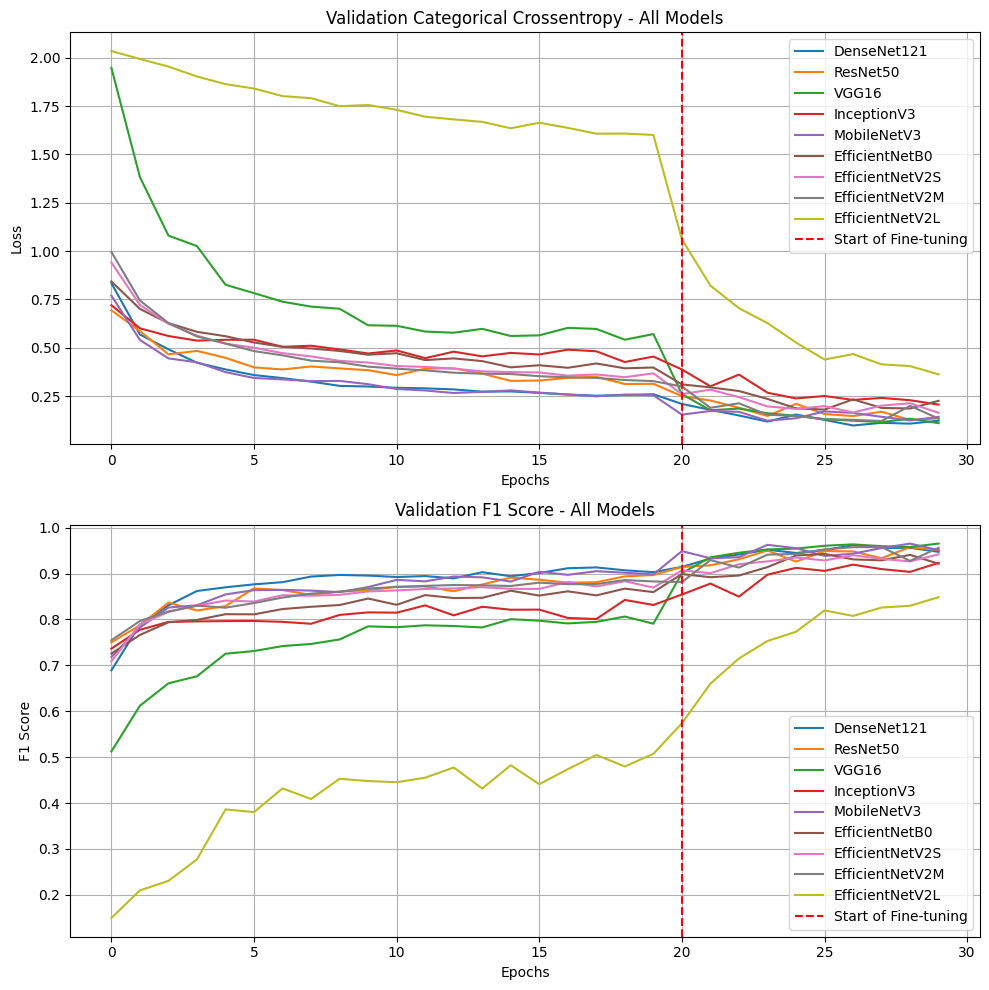

In [ ]:
import requests
import json
import matplotlib.pyplot as plt

# File ID extracted from the Google Drive sharable link
file_id = "1-Qj3C-eU9UVHvKc-85kgx_1mO9uX4NoM"
file_url = f"https://drive.google.com/uc?export=download&id={file_id}"

# Download the JSON file
response = requests.get(file_url)
response.raise_for_status()  # Check for request errors

# Parse the JSON content
data = response.json()

# Inspect the structure of the JSON file
print("Keys in the JSON file:", data.keys())
print("Example model data structure:", next(iter(data.values())))

# Extract models and metrics
models = data.keys()
# Prepare data for plotting
loss_data = {}
f1_data = {}

# Extract validation loss and F1 score for each model
for model_name, model_histories in data.items():
    val_losses = []
    val_f1_scores = []
    for history in model_histories:  # Iterate over training phases (if multiple)
        val_losses.extend(history['val_loss'])
        val_f1_scores.extend(history['val_f1_score'])
    loss_data[model_name] = val_losses
    f1_data[model_name] = val_f1_scores

# Assuming all models have the same number of epochs
epochs = range(len(next(iter(loss_data.values()))))
fine_tuning_epoch = 20  # Adjust based on your data if needed

# Plot settings
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Top subplot: Loss
for model, losses in loss_data.items():
    axs[0].plot(epochs, losses, label=model)
axs[0].axvline(x=fine_tuning_epoch, color='red', linestyle='--', label='Start of Fine-tuning')
axs[0].set_title('Validation Categorical Crossentropy - All Models')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='best')
axs[0].grid(True)

# Bottom subplot: F1 Score
for model, f1_scores in f1_data.items():
    axs[1].plot(epochs, f1_scores, label=model)
axs[1].axvline(x=fine_tuning_epoch, color='red', linestyle='--', label='Start of Fine-tuning')
axs[1].set_title('Validation F1 Score - All Models')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('F1 Score')
axs[1].legend(loc='best')
axs[1].grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Save the figure
fig.savefig('model_performance_plots.png', dpi=300, bbox_inches='tight')